<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/0721_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense


입력 X_train shape: (6892, 20, 1), 출력 y_train shape: (6892, 5, 1)
Epoch 1/50


/tmp/ipython-input-8-351977584.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T') # T : 분(minutes) 의미
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0427
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0033
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0033
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0033
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0033
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0033
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0033
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0033
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0033
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032
Epoch 11/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032
Epoch 12/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0033
Epoch 13/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0033
Epoch 14/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032
Epoch 15/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032


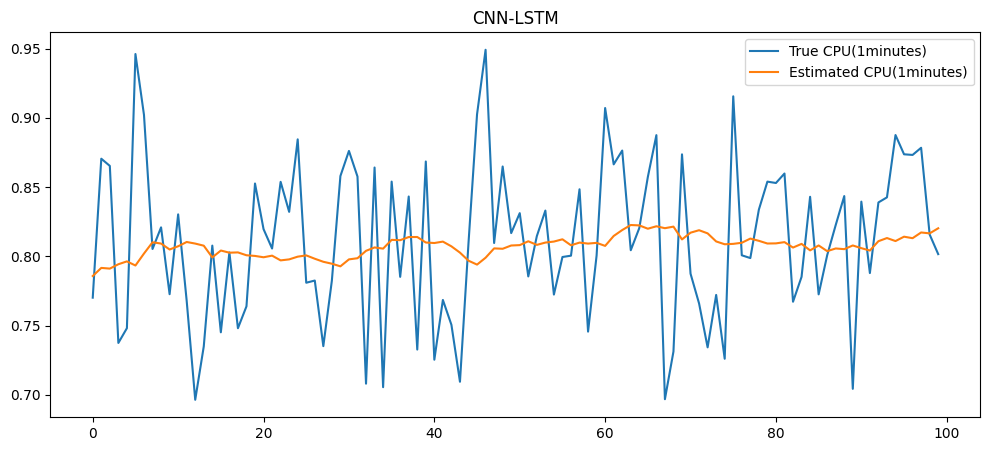

In [8]:
#1. data
np.random.seed(42) # 매번 돌릴때마다 같은 결과 나오도록 seed
days = 30 # 5분 단위 한 달 데이터
points_per_day = 24 * 12
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T') # T : 분(minutes) 의미

cpu = 50 + 30*np.sin(np.linspace(0, 10, total_points)) + np.random.normal(0, 5, total_points) # 평균 0, 표준편차 5

df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

# 2. 정규화
scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

# 3. sequence 생성 (시계열 -> 예측)
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset)-past_steps-future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5
X, y = create_sequences(scaled_cpu, past_steps, future_steps)

# 8:2 학습
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"입력 X_train shape: {X_train.shape}, 출력 y_train shape: {y_train.shape}")

# 5. CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, activation='relu'))
model.add(Dense(future_steps))  # future step에서의 CPU 예측
model.compile(optimizer='adam', loss='mse')


model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), # -1: numpy가 알아서 차원 계산하도록
          epochs=50, batch_size=16, verbose=1)


# 6. prediction
pred = model.predict(X_test)
pred = pred.reshape(-1, future_steps)  # 미래 5분 예측
y_true = y_test.reshape(-1, future_steps)

# visualization
plt.figure(figsize=(12,5))
plt.plot(y_true[:100,0], label="True CPU(1minutes)")
plt.plot(pred[:100,0], label="Estimated CPU(1minutes)")
plt.legend()
plt.title("CNN-LSTM")
plt.show()


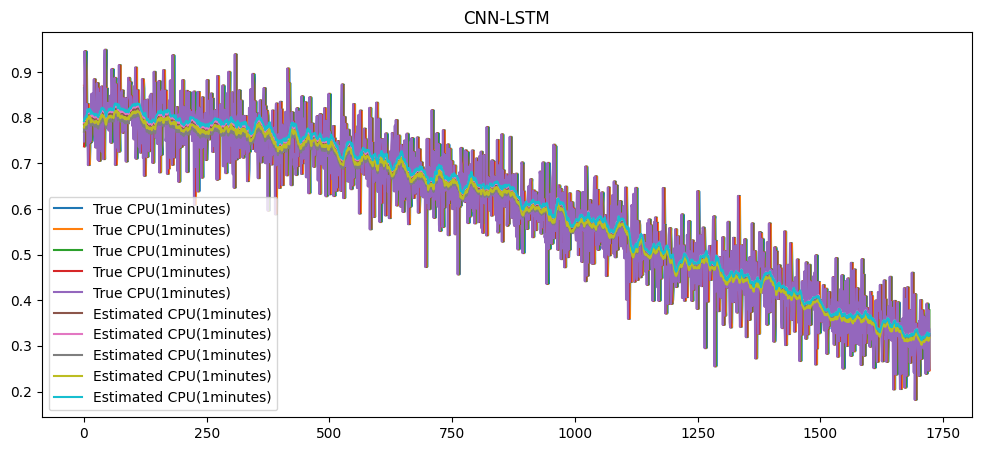

In [10]:

# visualization
plt.figure(figsize=(12,5))
plt.plot(y_true, label="True CPU(1minutes)")
plt.plot(pred, label="Estimated CPU(1minutes)")
plt.legend()
plt.title("CNN-LSTM")
plt.show()

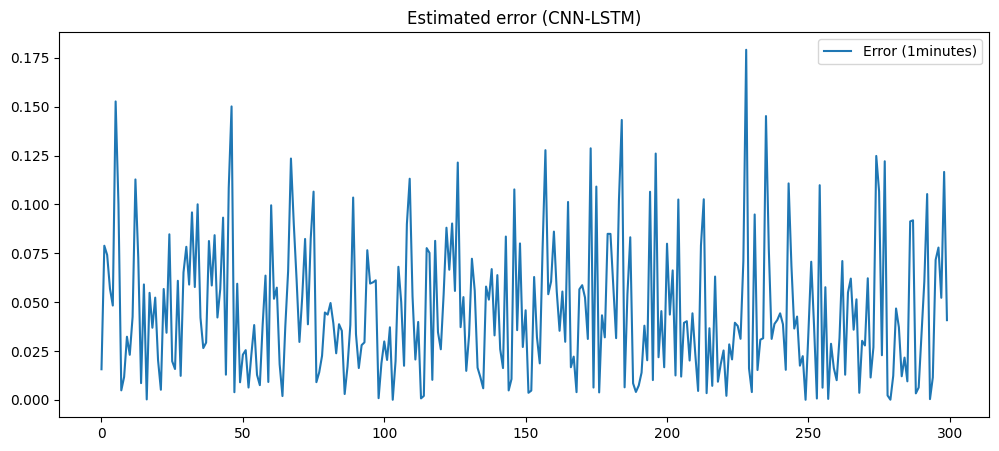

0.0034773308794861565


In [18]:
# visualization [estimated error]
plt.figure(figsize=(12,5))
plt.plot(abs(y_true[:300,0] - pred[:300,0]), label="Error (1minutes)")
plt.legend()
plt.title("Estimated error (CNN-LSTM)")
plt.show()

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_true[:,0],pred[:,0])) # 전체 mse 결과

431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0372
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0037
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0036
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0036
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0034
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0034
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0034
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0034
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0034
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0033
Epoch 11/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0034
Epoch 12/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0033
Epoch 13/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0033
Epoch 14/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0033
Epoch 15/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/ste

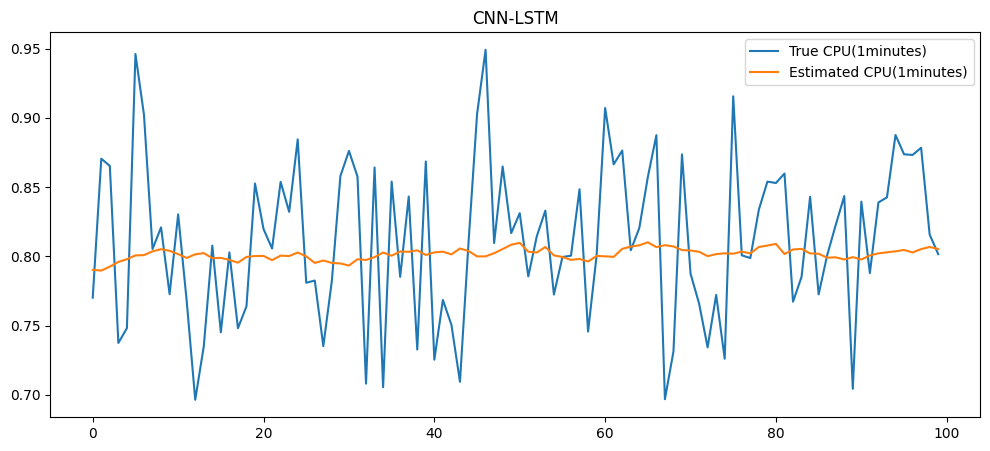

In [20]:

#1. data
np.random.seed(42) # 매번 돌릴때마다 같은 결과 나오도록 seed
days = 30 # 5분 단위 한 달 데이터
points_per_day = 24 * 12
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T') # T : 분(minutes) 의미

cpu = 50 + 30*np.sin(np.linspace(0, 10, total_points)) + np.random.normal(0, 5, total_points) # 평균 0, 표준편차 5

df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True)

# 2. 정규화
scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

# 3. sequence 생성 (시계열 -> 예측)
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset)-past_steps-future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5
X, y = create_sequences(scaled_cpu, past_steps, future_steps)

# 8:2 학습
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"입력 X_train shape: {X_train.shape}, 출력 y_train shape: {y_train.shape}")

# 5. CNN-LSTM

# CNN을 더쌓아
from tensorflow.keras.layers import Bidirectional, Dropout

model = Sequential()

# CNN 두 층
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))  # 추가 CNN
model.add(MaxPooling1D(pool_size=2))

# Bidirectional LSTM --> 양방향 패턴 학습
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # 첫번째 BiLSTM
model.add(Dropout(0.2))  # 과적합 방지
model.add(Bidirectional(LSTM(32)))  # 두번째 BiLSTM

model.add(Dense(64, activation='relu'))  # 추가 Dense
model.add(Dense(future_steps))  # 미래 step 예측

model.compile(optimizer='adam', loss='mse')

print(model.summary())

model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), # -1: numpy가 알아서 차원 계산하도록
          epochs=50, batch_size=16, verbose=1)


# 6. prediction
pred = model.predict(X_test)
pred = pred.reshape(-1, future_steps)  # 미래 5분 예측
y_true = y_test.reshape(-1, future_steps)

# visualization
plt.figure(figsize=(12,5))
plt.plot(y_true[:100,0], label="True CPU(1minutes)")
plt.plot(pred[:100,0], label="Estimated CPU(1minutes)")
plt.legend()
plt.title("CNN-LSTM")
plt.show()



In [21]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_true[:,0],pred[:,0]))

0.0035055497567857297


2. A Resource Utilization Prediction Model for Cloud Data Centers Using Evolutionary Algorithms and Machine Learning Techniques

GA: 로컬 최소 탈출 → 더 다양한 후보 탐색

PSO: 빠른 수렴
Adam 대신 GA-PSO로 가중치 진화 최적화

결과: Adam으로 학습한 CNN-LSTM보다 MAE 20~30% 감소 (논문 기준)



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# make dataset
np.random.seed(42)
days = 30
points_per_day = 24 * 12
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T') # T : 분(minutes) 의미

cpu = 50 + 30*np.sin(np.linspace(0, 10, total_points)) + np.random.normal(0, 5, total_points) # 평균 0, 표준편차 5

df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

# normalization
scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

# 3. make sequence for estimating future data (과거 20개 → 미래 5개 예측)
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset)-past_steps-future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5
X_seq, y_seq = create_sequences(scaled_cpu, past_steps, future_steps)

# 8:2 학습/테스트 분리
train_size = int(len(X_seq)*0.8)
X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
y_train_seq, y_test_seq = y_seq[:train_size], y_seq[train_size:]

print(f"[CNN-LSTM] input shape: {X_train_seq.shape}, output shape: {y_train_seq.shape}")

# =======================================================
# 4. CNN-LSTM 모델
# =======================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, activation='relu'))
model.add(Dense(future_steps))
model.compile(optimizer='adam', loss='mse')

# 학습
model.fit(X_train_seq, y_train_seq.reshape((y_train_seq.shape[0], -1)),
          epochs=10, batch_size=16, verbose=1)

# 예측
pred_seq = model.predict(X_test_seq)
pred_seq = pred_seq.reshape(-1, future_steps)
y_true_seq = y_test_seq.reshape(-1, future_steps)

# CNN-LSTM MSE
mse_cnnlstm = mean_squared_error(y_true_seq.flatten(), pred_seq.flatten())
print("CNN-LSTM MSE:", mse_cnnlstm)



/tmp/ipython-input-3-2892869875.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T') # T : 분(minutes) 의미


[CNN-LSTM] input shape: (6892, 20, 1), output shape: (6892, 5, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0506
Epoch 2/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033
Epoch 3/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033
Epoch 4/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033
Epoch 5/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033
Epoch 6/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0033
Epoch 7/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033
Epoch 8/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033
Epoch 9/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0032
Epoch 10/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
CNN-LSTM MSE: 0.003522657042776653


In [ ]:
# =======================================================
# 5. GA-PSO + FLNN 방식
# =======================================================
# GA-PSO는 단일 step 예측 (단변수 회귀 형태)
# 과거 20step → 미래 1step

def create_flnn_data(dataset, past_steps=20):
    X, y = [], []
    for i in range(len(dataset)-past_steps-1):
        X.append(dataset[i:i+past_steps].flatten())   # 과거 20step
        y.append(dataset[i+past_steps])               # 미래 1step
    return np.array(X), np.array(y)

X_flnn, y_flnn = create_flnn_data(scaled_cpu, past_steps=20)
train_size_flnn = int(len(X_flnn)*0.8) # 데이터셋의 총 길이의 80%로 학습 데이터 크기를 정하기.
X_train_flnn, X_test_flnn = X_flnn[:train_size_flnn], X_flnn[train_size_flnn:]
y_train_flnn, y_test_flnn = y_flnn[:train_size_flnn], y_flnn[train_size_flnn:]


# --- FLNN Forward ---
def flnn_forward(X, weights):
    return np.dot(X, weights)

# --- Fitness (MAE) ---
def fitness_function(weights, X, y):
    y_pred = flnn_forward(X, weights)
    return np.mean(np.abs(y - y_pred))

# --- 초기 Population ---
def init_population(pop_size, weight_dim):
    return np.random.uniform(-1, 1, (pop_size, weight_dim))

# --- GA+PSO 최적화 ---
def ga_pso_optimize(X, y, pop_size=20, max_gen=50, w=0.5, c1=1.5, c2=1.5):
    dim = X.shape[1]
    population = init_population(pop_size, dim)
    velocity = np.zeros_like(population)

    # 초기 fitness
    fitness = np.array([fitness_function(w, X, y) for w in population])
    pbest = population.copy()
    pbest_fitness = fitness.copy()
    gbest = population[np.argmin(fitness)]

    for gen in range(max_gen):
        # GA: crossover + mutation
        idx = np.random.choice(pop_size, pop_size, replace=True)
        crossover_pop = (population + population[idx]) / 2  # 간단 평균 crossover
        mutation = np.random.uniform(-0.1,0.1,crossover_pop.shape)
        population = crossover_pop + mutation

        # PSO 업데이트
        for i in range(pop_size):
            velocity[i] = (w*velocity[i]
                           + c1*np.random.rand()*(pbest[i]-population[i])
                           + c2*np.random.rand()*(gbest-population[i]))
            population[i] += velocity[i]

        # fitness 업데이트
        fitness = np.array([fitness_function(w, X, y) for w in population])

        # pbest/gbest 업데이트
        for i in range(pop_size):
            if fitness[i] < pbest_fitness[i]:
                pbest[i] = population[i].copy()
                pbest_fitness[i] = fitness[i]
        gbest = population[np.argmin(fitness)]

    return gbest


# GA-PSO로 최적 가중치 찾기
best_weights = ga_pso_optimize(X_train_flnn, y_train_flnn, pop_size=30, max_gen=100)

# FLNN 예측
y_pred_flnn = flnn_forward(X_test_flnn, best_weights)
mse_flnn = mean_squared_error(y_test_flnn, y_pred_flnn)
print("GA-PSO FLNN MSE:", mse_flnn)


print("\n=== 최종 비교 ===")
print(f"CNN-LSTM MSE   : {mse_cnnlstm:.6f}")
print(f"GA-PSO FLNN MSE: {mse_flnn:.6f}")

# 시각화
plt.figure(figsize=(12,5))
plt.plot(y_test_flnn[:200], label="True CPU")
plt.plot(y_pred_flnn[:200], label="FLNN Predicted")
plt.legend()
plt.title("GA-PSO FLNN")
plt.show()
